<a href="https://colab.research.google.com/github/MohammadAliAfsahi/Machine-Learning-and-Deep-Learning/blob/master/Housing_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price prediction

In [0]:
# In order to download and extract the dataset in .tgz format we can use following lines of code

# import os
# import tarfile
# from six.moves import urllib
# DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
# HOUSING_PATH = "datasets/housing"
# HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
# def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
# if not os.path.isdir(housing_path):
# os.makedirs(housing_path)
# tgz_path = os.path.join(housing_path, "housing.tgz")
# urllib.request.urlretrieve(housing_url, tgz_path)
# housing_tgz = tarfile.open(tgz_path)
# housing_tgz.extractall(path=housing_path)
# housing_tgz.close()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal

In [3]:
def load_dataset(file_path):
  
  return pd.read_csv(file_path)

url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'

dataset = load_dataset(url)

dataset.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
dataset.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
dataset.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

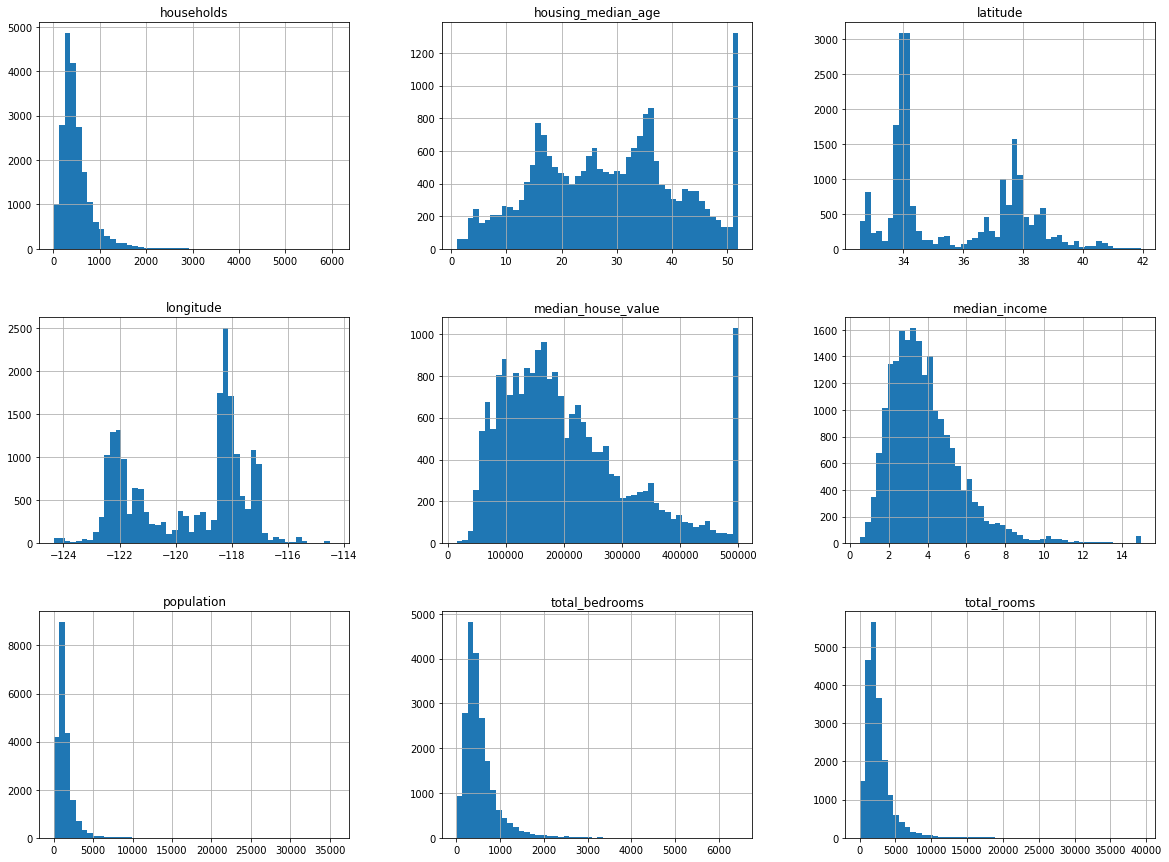

In [7]:
%matplotlib inline

dataset.hist(bins=50, figsize=(20,15))

plt.show()

In [0]:
def split_train_test(data, test_ratio, *args): # there is method in sklearn with similiar objective but I prefered to do it manually
  
  shuffled_indices = np.random.permutation(len(data))
  
  test_set_size = int(len(data) * test_ratio)
  
  test_indices = shuffled_indices[:test_set_size]
  
  train_indices = shuffled_indices[test_set_size:]
  
  return data.iloc[train_indices], data.iloc[test_indices]
 
  
def test_set_check(identifier, test_ratio, hash):
  
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio


def split_train_test(data, test_ratio, id_column, hash=hashlib.md5):
  
  ids = data[id_column]
  
  in_test_set = ids.apply( lambda id_:test_set_check(id_, test_ratio, hash))
  
  return data.loc[~in_test_set], data.loc[in_test_set]
  
  
  
dataset_with_id = dataset.reset_index()

X_train, X_test = split_train_test(dataset_with_id, 0.2, "index")

# or we can choose create an Id column for identifier of each districts

dataset_with_id['id'] = dataset['longitude'] * 1000 + dataset['latitude']

X_train, X_test = split_train_test(dataset_with_id, 0.2, 'id')

In [0]:
# or simply we can use sklearn train_test_split which has more efficient implementation

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

dataset['income_cat'] = np.ceil(dataset['median_income'] / 1.5)

dataset['income_cat'].where(dataset['median_income'] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(dataset, dataset['income_cat']):
  strat_train_set = dataset.loc[train_index]
  strat_test_set = dataset.loc[test_index]
  
dataset['income_cat'].value_counts() / len(dataset)

for set in (strat_train_set, strat_test_set):
  set.drop(['income_cat'], axis=1, inplace=True)


In [10]:
housing = strat_train_set.copy()

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
                      c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, figsize=(20,10)) # s option shows the radius of each 
                                                                                                        # circle which represents the 
                                                                                                        # districts population
plt.legend()

In [11]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687752
total_rooms           0.136422
housing_median_age    0.106985
households            0.066340
total_bedrooms        0.050081
population           -0.024622
longitude            -0.047586
latitude             -0.142814
Name: median_house_value, dtype: float64

In [12]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12,8)) # by default scatter_matrix will plot standard correlation coefficient of every 
                                           # numerical attribute against every other numerical attribute 11^2 =121 so we select those we need

housing.plot(kind='scatter', y='median_house_value', x='median_income', alpha=0.1)

In [13]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']

housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']

housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687752
rooms_per_household         0.145300
total_rooms                 0.136422
housing_median_age          0.106985
households                  0.066340
total_bedrooms              0.050081
population_per_household   -0.022435
population                 -0.024622
longitude                  -0.047586
latitude                   -0.142814
bedrooms_per_room          -0.258861
Name: median_house_value, dtype: float64

In [0]:
housing = strat_train_set.drop('median_house_value', axis=1)

housing_labels = strat_train_set['median_house_value'].copy()

# we have missing values in total_bedrooms attribute
# we have three options to deal with this

# housing.dropna(subset=['total_bedrooms']) # get rid of each districts with missing value

# housing.drop('total_bedrooms', axis=1) # drop attribute

# median = housing['total_bedrooms'].median()

# housing['total_bedrooms'].fillna(median) # fill with median or choose another statistics

imputer = SimpleImputer(strategy='median')

housing_numerical_attributes = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_numerical_attributes)

imputer.statistics_

# housing_numerical_attributes.median().values # this line will have same results as last line

X = imputer.transform(housing_numerical_attributes)

housing_transformed = pd.DataFrame(X, columns=housing_numerical_attributes.columns)

In [31]:
encoder = LabelEncoder()

housing_cat = housing['ocean_proximity']

housing_cat_encoded = encoder.fit_transform(housing_cat)

housing_cat_encoded

print(encoder.classes_)

# In order to distinguish these four categories we can use one Hot encoder 

encoder = OneHotEncoder(categories='auto')

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

housing_cat_1hot #Scipy sparse matrix

# we can both step in one step 

encoder = LabelBinarizer()

housing_cat_lb = encoder.fit_transform(housing_cat)

housing_cat_lb # numpy array

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [0]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
  
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  
  
  def fit(self, X, y=None):
    return self
  
  
  def transform(self, X, y=None):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
  
  

class DataFrameSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    return X[self.attribute_names].values
  

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
  
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [64]:

numerical_pipeline = Pipeline ([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler())
])

# or we can use full pipeline for both numerical and categorical attributes as follow

numerical_attributes = list(housing_numerical_attributes)

categorical_attributes = ['ocean_proximity']

numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_attributes)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attributes_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributes)),
    ('label_binarizer', MyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-1.34061366,  0.81549736, -0.04911198, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.57167919, -0.73324997,  0.7474863 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.22575325, -1.32748233,  0.03054785, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.20078859, -1.33684032, -0.92537009, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.51176401, -0.57416414, -1.64230855, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78138233, -0.82682987, -0.28809147, ...,  0.        ,
         0.        ,  0.        ]])

In [73]:
linear_regression = LinearRegression()

linear_regression.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]

some_label = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("prediction:\t", linear_regression.predict(some_data_prepared))

print("Labels:\t", list(some_label))

housing_predictions = linear_regression.predict(housing_prepared)

mse = mean_squared_error(housing_labels, housing_predictions)

rmse = np.sqrt(mse)

print("root mean squar error:\t", rmse) # underfit

prediction:	 [396659.12817359 411472.23082704 228454.13525514  96705.71641328
 289523.91500568]
Labels:	 [500001.0, 500001.0, 174200.0, 91400.0, 434000.0]
root mean squar error:	 68501.96465501045


In [75]:
decision_tree = DecisionTreeRegressor()

decision_tree.fit(housing_prepared, housing_labels)

housing_predictions = decision_tree.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)

tree_rmse = np.sqrt(tree_mse)

print("root mean square for decision tree:\t", tree_rmse) # the main reason I didn't use test set is because I was not sure about the model 
                                  # I was going to use. So I let my test to be unseen. using decision tree will cause overfit

root mean square for decision tree:	 0.0


In [0]:
scores = cross_val_score(decision_tree, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10) # 10 folds

rmse_scores = np.sqrt(scores * (-1))

In [94]:
def display_scores(scores):
  print("Scores:",scores)
  print("Mean:",scores.mean())
  print("Standard deviation:",scores.std())

display_scores(rmse_scores)

Scores: [71445.90559175 71108.05185276 72508.9971638  67884.73139306
 74883.10801552 74116.83699422 69567.49077021 72473.02158362
 72901.22089705 71861.03294565]
Mean: 71875.0397207654
Standard deviation: 1946.9624399325307


In [96]:
linear_scores = cross_val_score(linear_regression, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

linear_rmse_scores = np.sqrt(linear_scores * (-1))

display_scores(linear_rmse_scores)

Scores: [66430.84467076 64703.73637141 66823.35880931 72590.89598896
 68485.97604484 72106.95906606 67827.46593209 68914.80048773
 70366.48421294 70183.29232284]
Mean: 68843.38139069467
Standard deviation: 2387.727317938403


In [99]:
random_forest_model = RandomForestRegressor()

random_forest_model.fit(housing_prepared, housing_labels)

random_forest_predictions = random_forest_model.predict(housing_prepared)

random_forest_mse = mean_squared_error(housing_labels, random_forest_predictions)

random_forest_rmse = np.sqrt(random_forest_mse)

print("random forest root mean squared error:\t", random_forest_rmse)

random_forest_scores = cross_val_score(random_forest_model, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(random_forest_scores * (-1))

display_scores(forest_rmse_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


random forest root mean squared error:	 22421.763954712922
Scores: [52771.73040585 49244.07232741 51518.53171137 55037.62447139
 54817.30456014 57378.91014042 51920.37593082 51531.64773919
 54599.07556374 55297.37037778]
Mean: 53411.66432281069
Standard deviation: 2290.09030400922


In [102]:
# Fine tune models

params_grid = [
    {'n_estimators':[3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}
]

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest, params_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [105]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [104]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [108]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print("Root Mean Squared Error Score :",np.sqrt(-mean_score), params)

Mean Score : 64586.77488589963 {'max_features': 2, 'n_estimators': 3}
Mean Score : 55673.56828642028 {'max_features': 2, 'n_estimators': 10}
Mean Score : 53272.20709804139 {'max_features': 2, 'n_estimators': 30}
Mean Score : 60132.16598745585 {'max_features': 4, 'n_estimators': 3}
Mean Score : 53602.7760014778 {'max_features': 4, 'n_estimators': 10}
Mean Score : 51247.61050756142 {'max_features': 4, 'n_estimators': 30}
Mean Score : 59586.2220368944 {'max_features': 6, 'n_estimators': 3}
Mean Score : 52650.17551850782 {'max_features': 6, 'n_estimators': 10}
Mean Score : 50488.300811797206 {'max_features': 6, 'n_estimators': 30}
Mean Score : 59603.01822603737 {'max_features': 8, 'n_estimators': 3}
Mean Score : 52754.01501919056 {'max_features': 8, 'n_estimators': 10}
Mean Score : 50390.58862322985 {'max_features': 8, 'n_estimators': 30}
Mean Score : 62678.970760818745 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
Mean Score : 54612.15214689679 {'bootstrap': False, 'max_featu

In [109]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.21550569e-02, 6.11748700e-02, 4.04228674e-02, 1.57425375e-02,
       1.46724119e-02, 1.50712764e-02, 1.45574012e-02, 3.91527727e-01,
       4.31995349e-02, 1.08190431e-01, 5.50152283e-02, 8.17898098e-03,
       1.55083556e-01, 3.14350537e-05, 1.70499873e-03, 3.27168637e-03])

In [111]:
# Let's find out importances of each attributes
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = numerical_attributes + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.39152772674566694, 'median_income'),
 (0.15508355623815478, 'INLAND'),
 (0.10819043136806215, 'pop_per_hhold'),
 (0.07215505693001645, 'longitude'),
 (0.061174870041217015, 'latitude'),
 (0.055015228317868585, 'bedrooms_per_room'),
 (0.04319953485847915, 'rooms_per_hhold'),
 (0.04042286737707786, 'housing_median_age'),
 (0.015742537537113556, 'total_rooms'),
 (0.015071276359075802, 'population'),
 (0.014672411876253547, 'total_bedrooms'),
 (0.014557401212797022, 'households'),
 (0.008178980984569722, '<1H OCEAN'),
 (0.003271686367090794, 'NEAR OCEAN'),
 (0.0017049987328724286, 'NEAR BAY'),
 (3.1435053684232576e-05, 'ISLAND')]

In [113]:
model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)

y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

predictions = model.predict(X_test_prepared)

model_mse = mean_squared_error(y_test, predictions)

model_rmse = np.sqrt(model_mse)

print('Model Root Mean Squared Error: ', model_rmse)

Model Root Mean Squared Error:  46273.46869670264


In [116]:
parameters = [
    {"kernel":['linear'],"C":[1.0,  10.0, 30.0] },
    {"kernel":['rbf'], "C":[2.0, 20.0, 60.0], 'gamma':['scale','auto']}
]
svm_regressor = SVR()

svr_grid_search = GridSearchCV(svm_regressor, parameters, cv=5, scoring='neg_mean_squared_error')

svr_grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1.0, 10.0, 30.0], 'kernel': ['linear']},
                         {'C': [2.0, 20.0, 60.0], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [118]:
svr_mse = svr_grid_search.best_score_
svr_rmse = np.sqrt(svr_mse * (-1))
print(svr_rmse)

75475.90514193225


In [119]:
svr_grid_search.best_params_

{'C': 30.0, 'kernel': 'linear'}

In [0]:
randomized_parameters = {
    'kernel':['linear', 'rbf'],
    'C':reciprocal(20, 200000),
    'gamma':expon(scale=1.0)
}
svm_Reg = SVR()

randomized_search = RandomizedSearchCV(svm_Reg, param_distributions=randomized_parameters, n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)

randomized_search.fit(housing_prepared, housing_labels)

In [0]:
randomized_mse = randomized_search.best_score_

randomized_rmse = np.sqrt(randomized_mse * (-1))

print(randomized_rmse)

In [0]:
randomized_search.best_params_